<a href="https://colab.research.google.com/github/YamanShqeirat/sahde-ml/blob/main/ShadeML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Environment Setup & Data Organization

### 0.1 Environment & Library versions (Colab)

In [1]:
# Colab environemnt set up
!pip -q install pandas pyarrow fastparquet geopandas shapely rasterio scikit-learn matplotlib seaborn

import os, sys, json, textwrap, zipfile, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.8 MB/s eta 0:00:00


### 0.2 Mount Google Drive and set up project directories

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/CSE475 - Final Project"

RANDOM_STATE = 42

# Standard subfolders (you created a "Datasets" folder already)
RAW_DIR     = os.path.join(PROJECT_ROOT, "Datasets")        # raw uploads
INTERIM_DIR = os.path.join(PROJECT_ROOT, "interim")         # cleaned/intermediate
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports_figures") # charts/tables

for p in [INTERIM_DIR, REPORTS_DIR]:
    os.makedirs(p, exist_ok=True)

print("Project root:", PROJECT_ROOT)


Mounted at /content/drive
Project root: /content/drive/MyDrive/CSE475 - Final Project


### 1.1 Inspect available raw datasets

In [3]:
from pathlib import Path

def walk_dir(d, exts=None):
    d = Path(d)
    for p in sorted(d.rglob("*")):
        if p.is_file():
            if exts is None or p.suffix.lower() in exts:
                size_mb = p.stat().st_size / (1024*1024)
                print(f"{p.relative_to(d)}  [{size_mb:,.2f} MB]")

print("== RAW ==")
walk_dir(RAW_DIR, exts={".csv", ".zip", ".tif", ".geojson", ".parquet", ".xlsx"})


== RAW ==
647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv  [0.10 MB]
All_LC_Sensor_Climate.csv  [34.10 MB]
GlobalLandTemperaturesByCity.csv  [508.15 MB]
HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif  [1.50 MB]
LULC_temp_prediction.csv  [83.00 MB]
Where_Will_Tree_Planting_Improve_Urban_Heat_Health%3F.csv  [113.03 MB]


### 1.2 Load & validate core datasets (Kaggle GLT, CAP LTER IET)

In [4]:
# Confirming data integrity of main CSV files
from pathlib import Path
import pandas as pd

# --- Kaggle: Global Land Temperatures by City ---
kaggle_path = Path(RAW_DIR) / "GlobalLandTemperaturesByCity.csv"
if not kaggle_path.exists():
    folder_alt = Path(RAW_DIR) / "GlobalLandTemperaturesByCity"
    candidates = list(folder_alt.rglob("*.csv")) if folder_alt.exists() else []
    if candidates:
        kaggle_path = candidates[0]

print(f"📂 Kaggle dataset path: {kaggle_path}")
temps_city = pd.read_csv(kaggle_path)
print(f"✅ Loaded Kaggle temperature data: {temps_city.shape[0]:,} rows × {temps_city.shape[1]} columns")
display(temps_city.head(3))

# --- CAP LTER: IET Measurements ---
iet_candidates = sorted(Path(RAW_DIR).rglob("*IET*measurements*.csv"))
assert len(iet_candidates) >= 1, "❌ IET measurements CSV not found in RAW_DIR"
iet_path = iet_candidates[0]

print(f"\n📂 CAP LTER dataset path: {iet_path}")
iet = pd.read_csv(iet_path)
print(f"✅ Loaded CAP LTER IET data: {iet.shape[0]:,} rows × {iet.shape[1]} columns")
display(iet.head(3))


📂 Kaggle dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/GlobalLandTemperaturesByCity.csv
✅ Loaded Kaggle temperature data: 8,599,212 rows × 7 columns


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E



📂 CAP LTER dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv
✅ Loaded CAP LTER IET data: 3,360 rows × 3 columns


,Subject ID,period,temperature
0,1A,"Sat, 8pm-12am",25.144467
1,1P,"Sat, 8pm-12am",26.779625
2,1E,"Sat, 8pm-12am",27.218750


### 1.3 Inspect schema and normalize column names

In [5]:
# What columns do I have, and what do they look like?

# Are the column names consistent and easy to work with?

# Are dates properly formatted (as datetimes, not strings)?

def peek(df, name, n=3):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    display(df.sample(min(n, len(df))).head(n))
    print(df.dtypes.head(20))

peek(temps_city, "GlobalLandTemperaturesByCity")
peek(iet, "CAP-LTER IET measurements")

def clean_cols(df):
    return df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

temps_city = clean_cols(temps_city)
iet        = clean_cols(iet)

# Parse dates when present
for c in ["dt", "date", "day", "time", "timestamp"]:
    if c in temps_city.columns:
        temps_city[c] = pd.to_datetime(temps_city[c], errors="coerce")
    if c in iet.columns:
        iet[c] = pd.to_datetime(iet[c], errors="coerce")


=== GlobalLandTemperaturesByCity ===
Shape: (8599212, 7)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
5649732,1890-09-01,21.229,1.151,Palmira,Colombia,4.02N,76.34W
8507870,1868-04-01,3.058,1.466,Zelenograd,Russia,55.45N,36.85E
2369936,1850-04-01,22.759,2.737,Fort Lauderdale,United States,26.52N,80.60W


dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

=== CAP-LTER IET measurements ===
Shape: (3360, 3)


,Subject ID,period,temperature
801,1P,"Mon, 12pm-4pm",35.339625
1980,4F,"Wed, 8pm-12am",24.447937
2963,1B,"Sat, 12am-4am",26.541687


Subject ID      object
period          object
temperature    float64
dtype: object


# Section 2 – Data Loading & Cleaning

### 2.1 IET period parsing + time-of-day bucketing
### 2.2 Phoenix-metro subset from Kaggle (numeric coords)

In [6]:
# Minimal filtering (make a slim, workable subset)

import re
import pandas as pd
import numpy as np

df = iet.copy()

# 1) Clean temperature to numeric
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")

# 2) Parse period like "Sat, 8pm-12am"
day_map = {"Mon":0,"Tue":1,"Wed":2,"Thu":3,"Fri":4,"Sat":5,"Sun":6}

def to_24h(hh, ampm):
    hh = int(hh)
    ampm = ampm.lower()
    if ampm == "am":
        return 0 if hh == 12 else hh
    else:  # pm
        return 12 if hh == 12 else hh + 12

def parse_period(s):
    # Expected formats, allow spaces: "Sat, 8pm-12am" or "Sun, 10 am - 2 pm"
    m = re.match(r"\s*([A-Za-z]{3})\s*,\s*(\d{1,2})\s*([ap]m)\s*-\s*(\d{1,2})\s*([ap]m)\s*$", str(s))
    if not m:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=["dow","start_hour","end_hour","duration_hr"])
    dow, h1, ampm1, h2, ampm2 = m.groups()
    s_h = to_24h(h1, ampm1)
    e_h = to_24h(h2, ampm2)
    # handle wrap-around (e.g., 8pm–12am crosses midnight)
    duration = (e_h - s_h) % 24
    duration = 24 if duration == 0 else duration
    return pd.Series([day_map.get(dow[:3], np.nan), s_h, e_h, duration], index=["dow","start_hour","end_hour","duration_hr"])

parsed = df["period"].apply(parse_period)
df = pd.concat([df.drop(columns=["period"]), parsed], axis=1)

# Optional: time-of-day bucket
def tod_bucket(h):
    if pd.isna(h): return np.nan
    h = int(h)
    if 5 <= h < 12:   return "morning"
    if 12 <= h < 17:  return "afternoon"
    if 17 <= h < 21:  return "evening"
    return "night"

df["tod"] = df["start_hour"].apply(tod_bucket)

# Quick sanity:
print(df.head())
print(df.describe(include="all"))

# Example EDA: mean temp by day-of-week and time-of-day
pivot = df.pivot_table(index="dow", columns="tod", values="temperature", aggfunc="mean")
display(pivot)


# Pick a city and country to anchor (Phoenix or your target). Kaggle uses many spellings—use contains.
city_mask = temps_city["city"].str.contains("Phoenix", case=False, na=False) | \
            temps_city["city"].str.contains("Tempe", case=False, na=False) | \
            temps_city["city"].str.contains("Mesa", case=False, na=False)
temps_az = temps_city.loc[city_mask].copy()

# Drop obviously empty temp rows
# The column name after clean_cols is 'averagetemperature'
if 'averagetemperature' in temps_az.columns:
    temps_az = temps_az.rename(columns={'averagetemperature': 'avg_temp_c'})

# Function to convert latitude/longitude strings to floats
def parse_lat_lon(coord_str):
    if pd.isna(coord_str): return np.nan
    s = str(coord_str).strip()
    if not s: return np.nan
    if s[-1].upper() == 'N':
        return float(s[:-1])
    elif s[-1].upper() == 'S':
        return -float(s[:-1])
    elif s[-1].upper() == 'E':
        return float(s[:-1])
    elif s[-1].upper() == 'W':
        return -float(s[:-1])
    else:
        try:
            return float(s)
        except ValueError:
            return np.nan

# Apply parsing to latitude and longitude columns and explicitly convert to float
temps_az['latitude'] = temps_az['latitude'].apply(parse_lat_lon).astype(float)
temps_az['longitude'] = temps_az['longitude'].apply(parse_lat_lon).astype(float)


# Keep only essential columns to start
keep_cols = [c for c in ["dt", "city", "country", "latitude", "longitude", "avg_temp_c"] if c in temps_az.columns]
temps_az = temps_az[keep_cols].dropna(subset=["avg_temp_c", "latitude", "longitude"])

peek(temps_az, "Kaggle temps (AZ subset)")

# For IET, pick a few candidate columns (adjust if your file names differ)
# We'll try to find likely columns semi-automatically.
possible_date_cols = [c for c in iet.columns if "date" in c or "time" in c or "dt" in c]
possible_lat_cols  = [c for c in iet.columns if "lat" in c]
possible_lon_cols  = [c for c in iet.columns if "lon" in c or "lng" in c or "long" in c]
print("Likely date cols:", possible_date_cols[:5])
print("Likely lat cols :", possible_lat_cols[:5])
print("Likely lon cols :", possible_lon_cols[:5])

iet_small = iet.copy()
# If you know exact names, set them explicitly here:
date_col = possible_date_cols[0] if possible_date_cols else None

# Keep a small working subset
# Modified to handle cases where no lat/lon columns are found in iet
keep_iet = [c for c in [date_col] if c] # Start with date_col if found
if possible_lat_cols: keep_iet.append(possible_lat_cols[0])
if possible_lon_cols: keep_iet.append(possible_lon_cols[0])

# If no columns were found, iet_small will remain empty. Add a check here.
if keep_iet:
    iet_small = iet_small[keep_iet].dropna(how="any")
    # Rename only if columns exist
    rename_dict = {}
    if date_col: rename_dict[date_col] = "date"
    if possible_lat_cols: rename_dict[possible_lat_cols[0]] = "lat"
    if possible_lon_cols: rename_dict[possible_lon_cols[0]] = "lon"
    iet_small = iet_small.rename(columns=rename_dict)
else:
    iet_small = pd.DataFrame() # Ensure iet_small is a DataFrame even if no cols are kept


peek(iet_small, "IET (small subset)")

  subject_id  temperature  dow  start_hour  end_hour  duration_hr      tod
0         1A    25.144467    5          20         0            4  evening
1         1P    26.779625    5          20         0            4  evening
2         1E    27.218750    5          20         0            4  evening
3         1B    26.791750    5          20         0            4  evening
4         2N          NaN    5          20         0            4  evening
       subject_id  temperature          dow   start_hour     end_hour  duration_hr    tod
count        3360  3219.000000  3360.000000  3360.000000  3360.000000       3360.0   3360
unique         80          NaN          NaN          NaN          NaN          NaN      4
top            1A          NaN          NaN          NaN          NaN          NaN  night
freq           42          NaN          NaN          NaN          NaN          NaN   1120
mean          NaN    27.605769     3.000000    10.000000    10.000000          4.0    NaN
std       

tod,afternoon,evening,morning,night
dow,,,,
0,29.401596,27.737227,28.250542,26.421991
1,27.963517,27.232587,27.759565,26.623240
2,28.063691,27.019723,27.455663,26.254867
3,28.972580,27.570504,27.584562,26.268521
4,29.136725,27.538305,28.202955,26.679862
5,28.592135,27.267843,28.033002,26.413402
6,29.015337,27.539759,28.185808,26.316606



=== Kaggle temps (AZ subset) ===
Shape: (8394, 6)


,dt,city,country,latitude,longitude,avg_temp_c
7534108,2005-10-01,Tempe,United States,32.95,-112.02,22.855
7532599,1880-01-01,Tempe,United States,32.95,-112.02,10.833
1784374,1919-07-01,Costa Mesa,United States,32.95,-117.77,19.134


dt            datetime64[ns]
city                  object
country               object
latitude             float64
longitude            float64
avg_temp_c           float64
dtype: object
Likely date cols: []
Likely lat cols : []
Likely lon cols : []

=== IET (small subset) ===
Shape: (0, 0)


""


Series([], dtype: object)


### 2.4 Save clean Phoenix and IET subsets to interim (parquet)

In [7]:
# Save clean interim subsets

temps_az_path = os.path.join(INTERIM_DIR, "kaggle_temps_az.parquet")
iet_small_path = os.path.join(INTERIM_DIR, "iet_small.parquet")
temps_az.to_parquet(temps_az_path, index=False)
iet_small.to_parquet(iet_small_path, index=False)
print("Saved:", temps_az_path, "|", iet_small_path)


Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/kaggle_temps_az.parquet | /content/drive/MyDrive/CSE475 - Final Project/interim/iet_small.parquet


# Section 3 – Exploratory Analysis & Baseline Modeling

### 3.1 Baseline: Logistic Regression with calendar + city + coords (no shade features yet)

In [8]:
# ### 3.1 Baseline: Logistic Regression with calendar + city + coords (fold-safe label)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

# Start from clean rows
base = temps_az.dropna(subset=["avg_temp_c"]).copy()

# Calendar features
if "dt" in base.columns:
    base["year"] = base["dt"].dt.year
    base["month"] = base["dt"].dt.month
    base["dayofyear"] = base["dt"].dt.dayofyear

target_col = "is_hot"          # will be filled fold-by-fold
num_cols   = [c for c in ["year","month","dayofyear","latitude","longitude"] if c in base.columns]
cat_cols   = [c for c in ["city","country"] if c in base.columns]
X_cols     = num_cols + cat_cols

# Build preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("lr", LogisticRegression(max_iter=1000, solver="lbfgs", class_weight=None, random_state=RANDOM_STATE))
])

# Custom CV loop to compute fold-specific threshold on TRAIN ONLY (prevents label leakage)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, rocs = [], [], []
fold_info = []

for k, (tr, te) in enumerate(cv.split(base[X_cols], np.zeros(len(base)))):
    # Compute threshold on TRAIN set only
    thr = base.iloc[tr]["avg_temp_c"].quantile(0.70)
    y_train = (base.iloc[tr]["avg_temp_c"] >= thr).astype(int).values
    y_test  = (base.iloc[te]["avg_temp_c"] >= thr).astype(int).values

    # Fit on training fold
    X_train = base.iloc[tr][X_cols]
    X_test  = base.iloc[te][X_cols]
    clf.fit(X_train, y_train)

    # Predict on test fold
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    # Guard against single-class in fold (rare but possible)
    try:
        rocs.append(roc_auc_score(y_test, y_prob))
    except ValueError:
        rocs.append(np.nan)

    fold_info.append({
        "fold": k+1,
        "thr_celsius": float(thr),
        "train_pos_rate": float(y_train.mean()),
        "test_pos_rate": float(y_test.mean()),
        "acc": accs[-1],
        "f1": f1s[-1],
        "roc_auc": rocs[-1],
        "n_train": int(len(tr)),
        "n_test": int(len(te)),
    })

# Report
acc_m, acc_s = np.nanmean(accs), np.nanstd(accs)
f1_m,  f1_s  = np.nanmean(f1s),  np.nanstd(f1s)
roc_m, roc_s = np.nanmean(rocs), np.nanstd(rocs)

print(f"Baseline (fold-safe 70th pct):")
print(f"  Accuracy  {acc_m:.3f} ± {acc_s:.3f}")
print(f"  F1        {f1_m:.3f} ± {f1_s:.3f}")
print(f"  ROC-AUC   {roc_m:.3f} ± {roc_s:.3f}")

# Optional: show fold diagnostics
diag = pd.DataFrame(fold_info)
display(diag)


Baseline (fold-safe 70th pct):
  Accuracy  0.622 ± 0.020
  F1        0.001 ± 0.001
  ROC-AUC   0.730 ± 0.011


,fold,thr_celsius,train_pos_rate,test_pos_rate,acc,f1,roc_auc,n_train,n_test
0,1,23.7760,0.300372,0.310304,0.631328,0.000000,0.745419,6715,1679
1,2,23.9700,0.300372,0.294223,0.649196,0.000000,0.737449,6715,1679
2,3,24.0990,0.300074,0.273973,0.623585,0.000000,0.713721,6715,1679
3,4,23.6566,0.300074,0.325789,0.589637,0.000000,0.726305,6715,1679
4,5,23.9830,0.300179,0.293206,0.613826,0.003077,0.729435,6716,1678


### 3.2 Temperature time-series sanity check (monthly mean, AZ subset)

💾 Saved figure: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/monthly_mean_temp.png
Range: 6.6°C – 32.8°C | mean=19.9°C


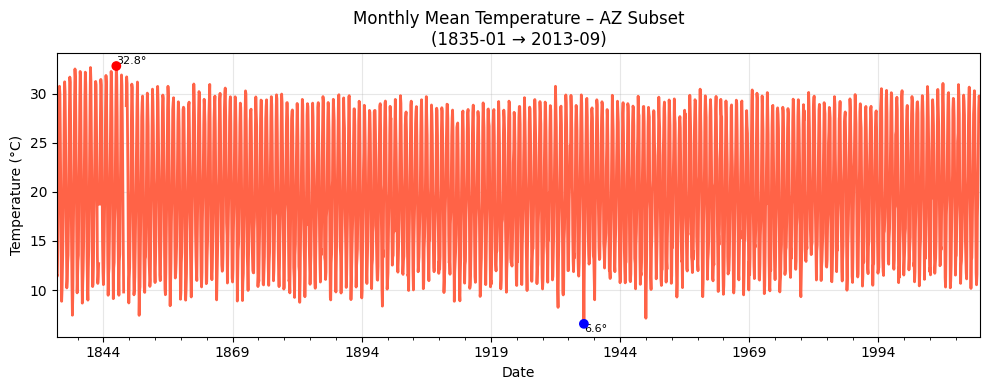

In [9]:
# ### 3.2 Temperature time-series sanity check (monthly mean, AZ subset)
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.figure(figsize=(10, 4))

if "dt" in temps_az.columns and np.issubdtype(temps_az["dt"].dtype, np.datetime64):
    ts = (
        temps_az
        .set_index("dt")["avg_temp_c"]
        .resample("M")
        .mean()
        .rename("Monthly Mean Temp (°C)")
    )
    if ts.empty:
        print("⚠️ No valid datetime values in dt column — skipping time series plot.")
    else:
        start, end = ts.index.min(), ts.index.max()
        ts.plot(color="tomato", lw=2)
        plt.title(f"Monthly Mean Temperature – AZ Subset\n({start:%Y-%m} → {end:%Y-%m})")
        plt.xlabel("Date")
        plt.ylabel("Temperature (°C)")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        fig_path = os.path.join(REPORTS_DIR, "monthly_mean_temp.png")
        plt.savefig(fig_path, dpi=160, bbox_inches="tight")
        print(f"💾 Saved figure: {fig_path}")
        print(f"Range: {ts.min():.1f}°C – {ts.max():.1f}°C | mean={ts.mean():.1f}°C")

        # Annotate extremes (optional)
        hottest = ts.idxmax()
        coldest = ts.idxmin()
        plt.scatter([hottest, coldest], [ts.max(), ts.min()],
                    color=["red","blue"], zorder=5)
        plt.text(hottest, ts.max(), f"{ts.max():.1f}°", ha="left", va="bottom", fontsize=8)
        plt.text(coldest, ts.min(), f"{ts.min():.1f}°", ha="left", va="top", fontsize=8)
else:
    sns.histplot(temps_az["avg_temp_c"], bins=50, color="skyblue")
    plt.title("Temperature Distribution (AZ subset)")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Count")
    plt.tight_layout()

    fig_path = os.path.join(REPORTS_DIR, "temperature_distribution.png")
    plt.savefig(fig_path, dpi=160, bbox_inches="tight")
    print(f"💾 Saved figure: {fig_path}")
